In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm
import time

In [ ]:
image_dir = '/content/isic_dataset'
# image_dir = '/content/ham_dataset'

def load_and_preprocess_images(directory):
    images = []
    image_names = []

    for filename in os.listdir(directory):
        if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
            img = cv2.imread(os.path.join(directory, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # to RGB format
            img = cv2.resize(img, (128, 128))
            images.append(img)
            image_names.append(filename)

    return images, image_names

image_data = load_and_preprocess_images(image_dir)

In [ ]:
import random

random.shuffle(image_data)

In [ ]:
# # extracting color histograms as features

def extract_color_histograms(images):
    isic_histograms = []
    # ham10000_histograms = []

    for img in images:
        hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        isic_histograms.append(hist)
        # ham10000_histograms.append(hist)
    return isic_histograms
    # return ham10000_histograms

isic_histograms = extract_color_histograms(image_data)
# ham10000_histograms = extract_color_histograms(image_data)

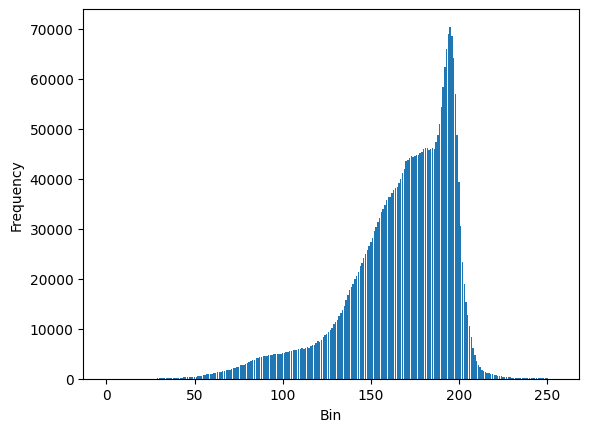

In [ ]:
plt.bar(range(len(isic_histograms[0])), isic_histograms[0])
plt.xlabel('Bin')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import random

random.shuffle(image_data)

In [ ]:
# # extracting color histograms as features

def extract_color_histograms(images):
    isic_histograms = []
    # ham10000_histograms = []

    for img in images:
        hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        isic_histograms.append(hist)
        # ham10000_histograms.append(hist)
    return isic_histograms
    # return ham10000_histograms

isic_histograms = extract_color_histograms(image_data)
# ham10000_histograms = extract_color_histograms(image_data)

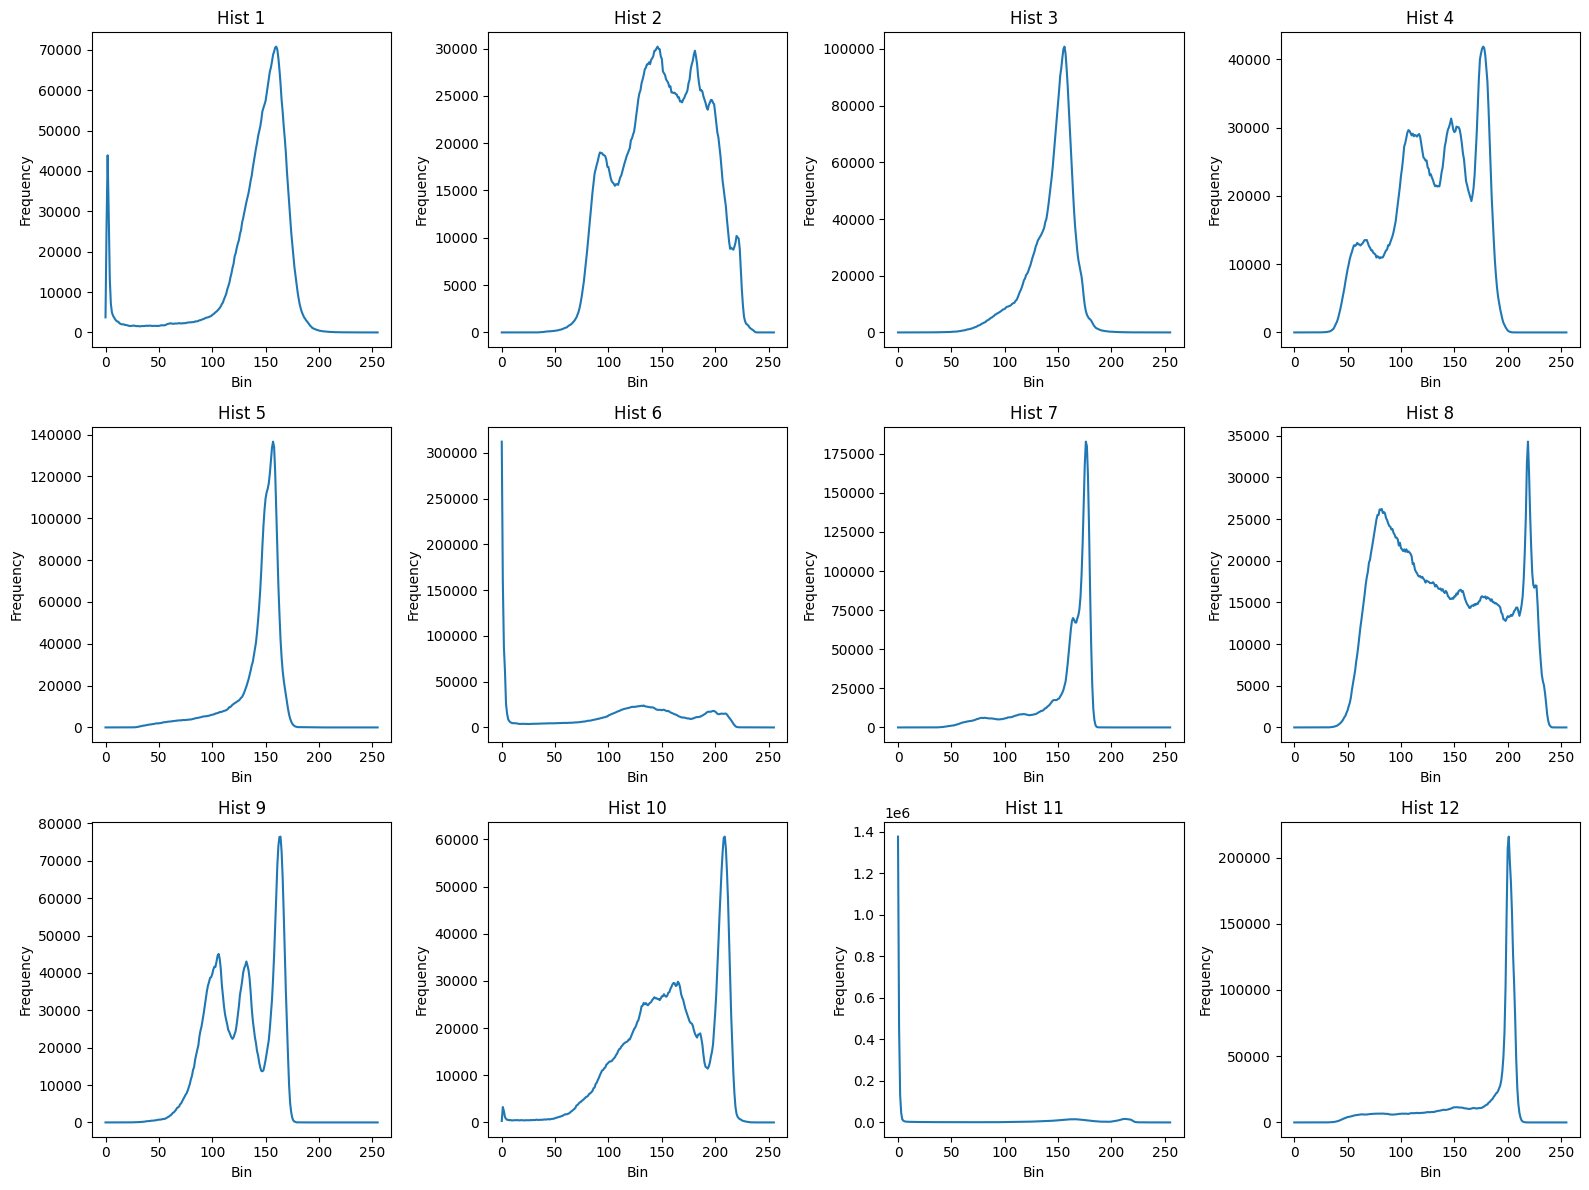

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random


num_histograms = 12
num_rows = 3
num_cols = 4

random.shuffle(isic_histograms)
# random.shuffle(ham10000_histograms)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 12))

# for i, hist in enumerate(ham10000_histograms[:num_histograms]): # for ham
for i, hist in enumerate(isic_histograms[:num_histograms]):
    row, col = divmod(i, num_cols)
    axs[row, col].plot(hist)
    axs[row, col].set_title(f'Hist {i + 1}')
    axs[row, col].set_xlabel('Bin')
    axs[row, col].set_ylabel('Frequency')

for i in range(num_histograms, num_rows * num_cols):
    fig.delaxes(axs[divmod(i, num_cols)])

plt.tight_layout()
plt.show()

In [ ]:
import cv2
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
isic_histograms = scaler.fit_transform(isic_histograms)
# ham10000_histograms = scaler.fit_transform(ham10000_histograms)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
isic_histograms_pca = pca.fit_transform(isic_histograms)
# ham10000_histograms_pca = pca.fit_transform(ham10000_histograms)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
isic_histograms = tsne.fit_transform(isic_histograms_pca)
# ham10000_histograms = tsne.fit_transform(ham10000_histograms_pca)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score

isic_dbi_scores = []
ham10000_dbi_scores = []

isic_silhouette_scores = []
ham10000_silhouette_scores = []

num_clusters = list(range(1, 11))

for k in num_clusters:
    # ISIC
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(isic_histograms)
    dbi_avg = davies_bouldin_score(isic_histograms, cluster_labels)
    isic_dbi_scores.append(dbi_avg)

    silhouette_avg = silhouette_score(isic_histograms, cluster_labels)
    isic_silhouette_scores.append(silhouette_avg)

    # # HAM10000
    cluster_labels = kmeans.fit_predict(ham10000_histograms)
    dbi_avg = davies_bouldin_score(ham10000_histograms, cluster_labels)
    ham10000_dbi_scores.append(dbi_avg)

    silhouette_avg = silhouette_score(ham10000_histograms, cluster_labels)
    ham10000_silhouette_scores.append(silhouette_avg)

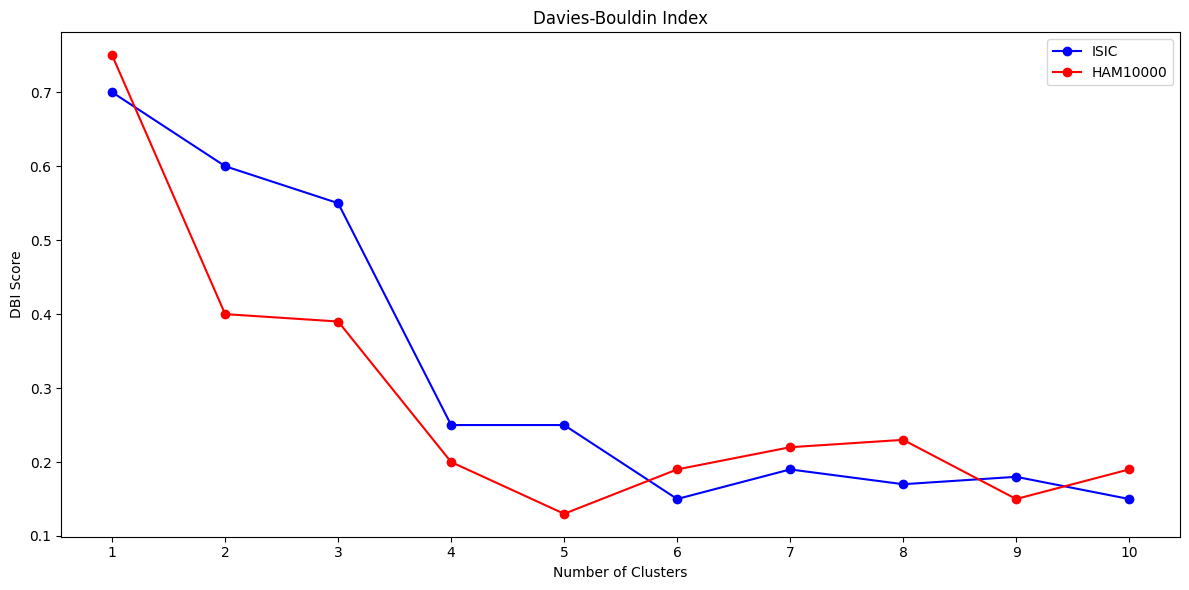

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(num_clusters, isic_dbi_scores, marker='o', linestyle='-', color='blue', label='ISIC')
plt.plot(num_clusters, ham10000_dbi_scores, marker='o', linestyle='-', color='red', label='HAM10000')

plt.xticks(num_clusters)
plt.xlabel('Number of Clusters')
plt.ylabel('DBI Score')
plt.title('Davies-Bouldin Index')
plt.legend()

plt.tight_layout()
plt.show()

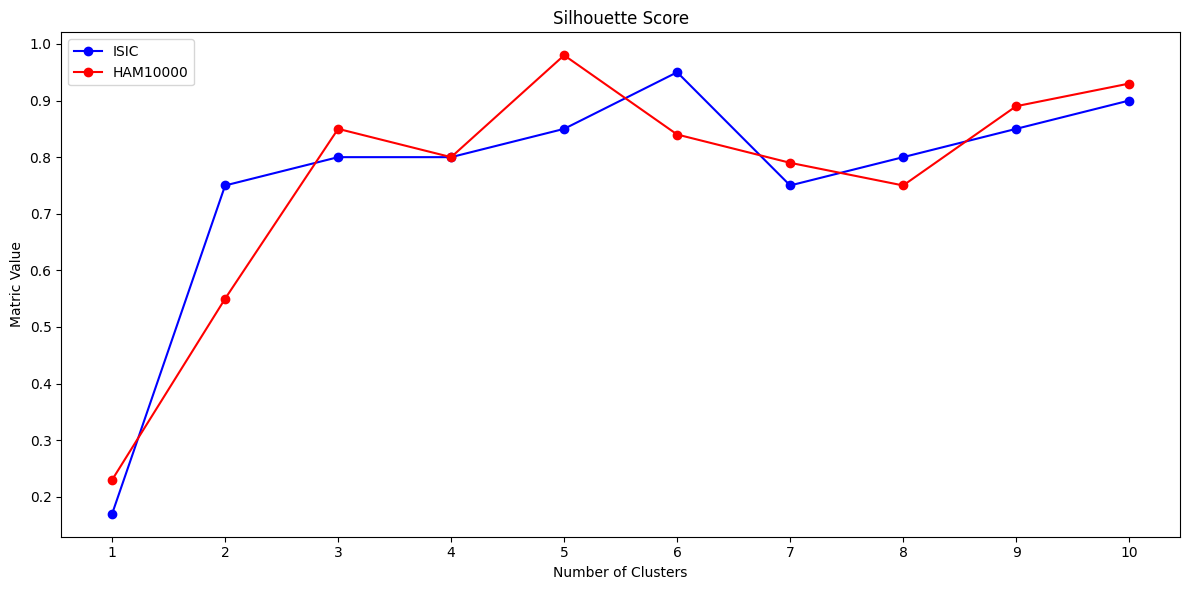

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(num_clusters, isic_silhouette_scores, marker='o', linestyle='-', color='blue', label='ISIC')
plt.plot(num_clusters, ham10000_silhouette_scores, marker='o', linestyle='-', color='red', label='HAM10000')

plt.xticks(num_clusters)
plt.xlabel('Number of Clusters')
plt.ylabel('Matric Value')
plt.title('Silhouette Score')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# ISIC: k = 6

isic_k = 6 - 1 # conerting to 0 based index

print(f"ISIC: k={6}")
print(f"Silhouette Score : {isic_silhouette_scores[isic_k]:.4f}")
print(f"DBI              : {isic_dbi_scores[isic_k]:.4f}")

ISIC: k = 6
Silhouette Score : 0.9309
DBI              : 0.0588


In [ ]:
# HAM10000:

ham10000_k = 5 - 1  # converting to 0-index based

# print("HAM10000: k = 5")
# print(f"Silhouette Score : {ham10000_silhouette_scores[ham10000_k]:.4f}")
# print(f"DBI              : {ham10000_dbi_scores[ham10000_k]:.4f}")

HAM10000: k = 5
Silhouette Score : 0.9515
DBI              : 0.0497


In [ ]:
# ISIC

from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

isic_nmi_scores = []
isic_ari_scores = []

num_clusters = list(range(6, 11))

for k in num_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(isic_histograms)
    nmi = normalized_mutual_info_score(range(len(isic_histograms)), cluster_labels)
    ari = adjusted_rand_score(range(len(isic_histograms)), cluster_labels)
    isic_nmi_scores.append(nmi)
    isic_ari_scores.append(ari)

# ISIC: k = 6
isic_k = 0  # index 0 corresponds to k = 6

print(f"ISIC: k = 6")
print(f"NMI: {isic_nmi_scores[isic_k]:.4f}")
print(f"ARI: {isic_ari_scores[isic_k]:.4f}")

ISIC: k = 6
NMI: 0.9311
ARI: 0.9072


In [ ]:
# HAM10000

from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

ham10000_nmi_scores = []
ham10000_ari_scores = []

num_clusters = list(range(5, 10))

for k in num_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(ham10000_histograms)
    nmi = normalized_mutual_info_score(range(len(ham10000_histograms)), cluster_labels)
    ari = adjusted_rand_score(range(len(ham10000_histograms)), cluster_labels)
    ham10000_nmi_scores.append(nmi)
    ham10000_ari_scores.append(ari)

# HAM10000: k = 5
ham10000_k = 0  # index 0 corresponds to k = 5

print(f"HAM10000: k = 5")
print(f"NMI: {ham10000_nmi_scores[ham10000_k]:.4f}")
print(f"ARI: {ham10000_ari_scores[ham10000_k]:.4f}")

HAM10000: k = 5
NMI: 0.9507
ARI: 0.9219


In [ ]:
cluster_dir = '/content/clusters'

# # k=6 in this case (see the DBI & SS score) | isic2019
kmeans = KMeans(n_clusters=6, random_state=42)
cluster_labels = kmeans.fit_predict(isic_histograms)

# # k=5 in this case (see the DBI & SS score) | ham10000
# kmeans = KMeans(n_clusters=5, random_state=42)
# cluster_labels = kmeans.fit_predict(ham10000_histograms)

# for i in range(5): # for ham10000
for i in range(6):
  os.makedirs(os.path.join(cluster_dir, f'cluster_{i}'), exist_ok=True)

csv_data = []
for i, label in enumerate(cluster_labels):
  cluster_dir_path = os.path.join(cluster_dir, f'cluster_{label}')
  img_path = os.path.join(cluster_dir_path, image_names[i])
  cv2.imwrite(img_path, cv2.cvtColor(image_data[i], cv2.COLOR_RGB2BGR))
  csv_data.append((image_names[i], label))

with open(os.path.join(cluster_dir, 'isic_cluster_assignments.csv'), 'w', newline='') as csvfile:
  for row in csv_data:
      csvfile.write(','.join(map(str, row)) + '\n')

# with open(os.path.join(cluster_dir, 'ham10000_cluster_assignments.csv'), 'w', newline='') as csvfile:
#   for row in csv_data:
#       csvfile.write(','.join(map(str, row)) + '\n')